<a href="https://colab.research.google.com/github/Beerschtein/PyTorch/blob/main/Course_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Задание по итогам курса:**

- (упрощенное/для тех, у кого нет вебкамеры)
    1. Нужно написать приложение, которое будет получать на вход *изображение*.
    2. В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
    3. На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.

- (более сложное)
    1. Нужно написать приложение, которое будет считывать и выводить кадры с *веб-камеры*.
    2. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре.
    3. Человек показывает жесты руками, а алгоритм должен считать их и классифицировать. 
____________________
- Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.
- Как работать с веб-камерой на google colab https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab


У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/R2PGlaXDf6_HzQ

### Загрузим необходимые библиотеки, датасет для обучения сети распознавать жесты, подготовим и обучим нейросеть.

In [1]:
!pip install facenet-pytorch==2.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 6.6 MB/s 


In [2]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 1.4 MB/s 


In [3]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
from glob import glob
import sys, os
import argparse
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim
import PIL
from PIL import Image
import torchvision.transforms as tt
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import pandas as pd
import seaborn
from facenet_pytorch import MTCNN
import mediapipe as mp
import cv2

In [5]:
!wget 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1RtYxMV83aMhtcrQ7iLsDRa1k4hJZY2hw' -O data.zip

--2022-09-22 12:32:00--  https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1RtYxMV83aMhtcrQ7iLsDRa1k4hJZY2hw
Resolving drive.google.com (drive.google.com)... 142.251.16.138, 142.251.16.101, 142.251.16.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.16.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h1f7dp12r351pqqld1tbihm84u8m8og3/1663849875000/06840004559052771215/*/1RtYxMV83aMhtcrQ7iLsDRa1k4hJZY2hw?e=download&uuid=ab28a757-858f-4e60-a9c0-7046f431044b [following]
--2022-09-22 12:32:00--  https://doc-0o-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h1f7dp12r351pqqld1tbihm84u8m8og3/1663849875000/06840004559052771215/*/1RtYxMV83aMhtcrQ7iLsDRa1k4hJZY2hw?e=download&uuid=ab28a757-858f-4e60-a9c0-7046f431044b
Resolving doc-0o-18-docs.googleusercontent.com (doc-0o-18-docs.googleusercontent.com)... 

In [6]:
%%time
!unzip data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0013.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0014.png  
  inflating: leapges

In [7]:
images = glob('./leapgestrecog/leapGestRecog/**/**/*.png')

In [8]:
labels = [int(os.path.basename(img).split('_')[2])-1 for img in images] # отнимаем 1, чтобы нумерация классов начиналась с 0

images[:5], labels[:5]

(['./leapgestrecog/leapGestRecog/05/06_index/frame_05_06_0020.png',
  './leapgestrecog/leapGestRecog/05/06_index/frame_05_06_0116.png',
  './leapgestrecog/leapGestRecog/05/06_index/frame_05_06_0127.png',
  './leapgestrecog/leapGestRecog/05/06_index/frame_05_06_0077.png',
  './leapgestrecog/leapGestRecog/05/06_index/frame_05_06_0098.png'],
 [5, 5, 5, 5, 5])

In [9]:
len(images)

20000

In [10]:
class_nums_names = [(int((os.path.split(img)[0].split('/')[-1].split('_'))[0])-1, os.path.split(img)[0].split('/')[-1].split('_')[1:]) for img in images]
nums_names_classes = {}
for num, name in class_nums_names:
    if num not in nums_names_classes.keys():
        nums_names_classes[num] = name
        
sorted(nums_names_classes.items(), key = lambda x: x[0])

[(0, ['palm']),
 (1, ['l']),
 (2, ['fist']),
 (3, ['fist', 'moved']),
 (4, ['thumb']),
 (5, ['index']),
 (6, ['ok']),
 (7, ['palm', 'moved']),
 (8, ['c']),
 (9, ['down'])]

In [11]:
def num_to_classname(num):
    if num == 0:
        return 'palm'
    elif num == 1:
        return 'l'
    elif num == 2:
        return 'fist'
    elif num == 3:
        return 'fist_moved'
    elif num == 4:
        return 'thumb'
    elif num == 5:
        return 'index'
    elif num == 6:
        return 'ok'
    elif num == 7:
        return 'palm_moved'
    elif num == 8:
        return 'c'
    elif num == 9:
        return 'down'

### Разделим датасет на train и test.

In [12]:
test_size = 0.3
random_state = 1

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=test_size, random_state=random_state)

### Создадим объекты для необходимых трансформаций нашего датасета:

In [13]:
train_transformer = transforms.Compose([
                         transforms.Grayscale(num_output_channels=1),
                         transforms.RandomHorizontalFlip(),           
                         transforms.RandomRotation(30),
                         transforms.Resize((64,71)),               
                         transforms.ToTensor()]) 

val_transformer =  transforms.Compose([  
                         transforms.Grayscale(num_output_channels=1),
                         transforms.Resize((64,71)),
                         transforms.ToTensor()]) 

In [14]:
class GestureDataset(Dataset):
    def __init__(self, images_gestures, labels, transformer):      
        self.images = images_gestures
        self.labels = labels
        self.transformer = transformer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img =  Image.open(self.images[idx]) 
        img = self.transformer(img)
      
        return img, self.labels[idx]

### И создадим наши даталоадеры:

In [15]:
batch_size = 32

train_dataset = GestureDataset(X_train, y_train, train_transformer)
test_dataset = GestureDataset(X_val, y_val, val_transformer)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [16]:
classes_train = set(y_train)
print(f'Train Classes - {classes_train}')

Train Classes - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [17]:
digit_to_classname = {0:'palm', 1:'l', 2:'fist', 3:'fist moved', 4:'thumb', 5:'index', 6:'ok', 7:'palm moved', 8:'c', 9:'down'}

In [18]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 64, 71])


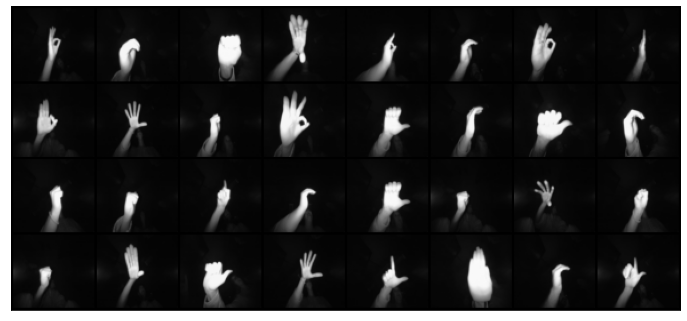

In [19]:
show_batch(test_dataloader)

In [20]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

### Проверим какое оборудование у нас:

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

### Опишем модель для распознавания жестов:

In [23]:
# Class ResNet

def conv_block(in_channels, out_channels, pool=False):
    
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
        
    return nn.Sequential(*layers)

def linear_block(input_dim, output_dim, activation = False, dropout = 0.3):
    
    layers = [nn.Linear(input_dim, output_dim),
             nn.Dropout(dropout)]
    if activation:
        layers.append(nn.ReLU())
        
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

### Скомпилируем и инициализируем модель.

In [25]:
model = ResNet(1, len(nums_names_classes)).to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

In [26]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [38]:
model = to_device(ResNet(1, len(classes_train)), device)

### Обучим модель.

In [27]:
# Model learning
%%time

epochs = 15

epoch_losses = []

for epoch in range(epochs):
    
    train_running_loss = 0.0
    total_acc_train = 0.0
    epoch_loss = []
    for data, labels in tqdm(train_dataloader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        train_running_loss += loss.item()
        epoch_loss.append(loss.item())
        
        acc = (outputs.argmax(dim=1) == labels).sum().item()
        total_acc_train += acc
        
        loss.backward()
        optimizer.step()
        
        
    val_running_loss, total_acc_val = 0.0, 0.0
    val_epoch_loss = []
    for data, labels in test_dataloader:
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = (data)
        loss = criterion(outputs, labels)
                
        val_running_loss += loss.item()
        val_epoch_loss.append(loss.item())
        
        acc = (outputs.argmax(dim=1) == labels).sum().item()
        total_acc_val += acc
        
    print(f'Epoch {epoch+1}, loss:, {np.mean(epoch_loss)}, Train acc:, {total_acc_train / len(train_dataset):.3f}  '
          f'Val loss:, {np.mean(val_epoch_loss)}, Val acc: {total_acc_val / len(test_dataset):.3f}')
    epoch_losses.append(epoch_loss)

100%|██████████| 438/438 [00:52<00:00,  8.39it/s]


Epoch 1, loss:, 2.2465012309622003, Train acc:, 0.522  Val loss:, 2.7964130265915648, Val acc: 0.297


100%|██████████| 438/438 [00:45<00:00,  9.70it/s]


Epoch 2, loss:, 1.6804452831070174, Train acc:, 0.418  Val loss:, 0.36891039611494286, Val acc: 0.871


100%|██████████| 438/438 [00:47<00:00,  9.28it/s]


Epoch 3, loss:, 0.2843653269635182, Train acc:, 0.907  Val loss:, 0.10967576624875135, Val acc: 0.968


100%|██████████| 438/438 [00:48<00:00,  9.10it/s]


Epoch 4, loss:, 0.10007149180488822, Train acc:, 0.968  Val loss:, 0.030016193462986538, Val acc: 0.992


100%|██████████| 438/438 [00:48<00:00,  8.97it/s]


Epoch 5, loss:, 0.0978008452539766, Train acc:, 0.969  Val loss:, 0.05578231933310583, Val acc: 0.982


100%|██████████| 438/438 [00:48<00:00,  8.96it/s]


Epoch 6, loss:, 0.07571258247915956, Train acc:, 0.977  Val loss:, 0.030303138427312814, Val acc: 0.993


100%|██████████| 438/438 [00:48<00:00,  9.01it/s]


Epoch 7, loss:, 0.06362562484423402, Train acc:, 0.982  Val loss:, 0.06425713117363209, Val acc: 0.983


100%|██████████| 438/438 [00:49<00:00,  8.93it/s]


Epoch 8, loss:, 0.08783138427670523, Train acc:, 0.974  Val loss:, 0.04461913780061606, Val acc: 0.988


100%|██████████| 438/438 [00:48<00:00,  8.99it/s]


Epoch 9, loss:, 0.0608725434403989, Train acc:, 0.983  Val loss:, 0.10464718753037426, Val acc: 0.981


100%|██████████| 438/438 [00:49<00:00,  8.89it/s]


Epoch 10, loss:, 0.06822355462096938, Train acc:, 0.980  Val loss:, 0.020530458911229958, Val acc: 0.990


100%|██████████| 438/438 [00:48<00:00,  8.98it/s]


Epoch 11, loss:, 0.0774647775927304, Train acc:, 0.981  Val loss:, 0.0564945080541099, Val acc: 0.986


100%|██████████| 438/438 [00:49<00:00,  8.93it/s]


Epoch 12, loss:, 0.08381600394925261, Train acc:, 0.980  Val loss:, 0.044261846993637916, Val acc: 0.992


100%|██████████| 438/438 [00:49<00:00,  8.92it/s]


Epoch 13, loss:, 0.04564541527200091, Train acc:, 0.988  Val loss:, 0.03329122572187039, Val acc: 0.994


100%|██████████| 438/438 [00:49<00:00,  8.93it/s]


Epoch 14, loss:, 0.05158278416980867, Train acc:, 0.987  Val loss:, 0.05671183378785524, Val acc: 0.991


100%|██████████| 438/438 [00:48<00:00,  8.97it/s]


Epoch 15, loss:, 0.10821842457989947, Train acc:, 0.978  Val loss:, 0.0833723057676494, Val acc: 0.978
CPU times: user 11min 52s, sys: 17.1 s, total: 12min 9s
Wall time: 14min 52s


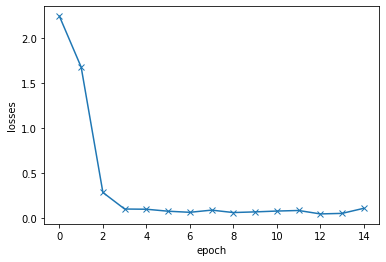

In [28]:
# Plot loss

losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses');

In [34]:
model = ResNet(1, len(classes_train)).to(device)

### Сохраним модель.

In [36]:
model_path = './gesture_classification_model_1.pth'
torch.save(model, model_path)

In [39]:
torch.save(model.state_dict(), './gesture_detection_model_dictionary.pth')

### Затем загрузим модель и проверим ее работоспособность.

In [ ]:
model = torch.load(model_path)

### Прогоним через нейронную сеть тестовый датасет:

torch.Size([32, 1, 64, 71])
torch.Size([10])


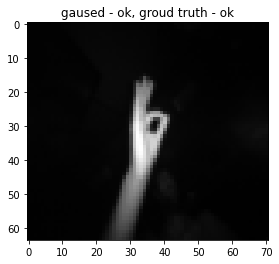

torch.Size([32, 1, 64, 71])
torch.Size([10])


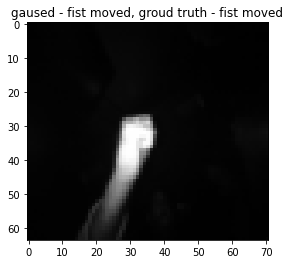

torch.Size([32, 1, 64, 71])
torch.Size([10])


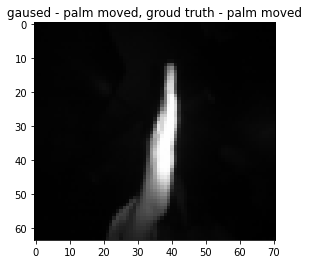

torch.Size([32, 1, 64, 71])
torch.Size([10])


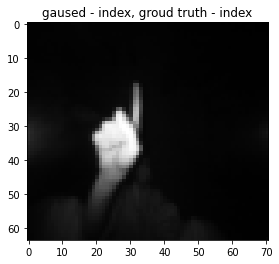

torch.Size([32, 1, 64, 71])
torch.Size([10])


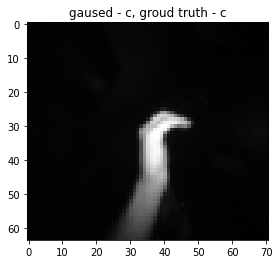

torch.Size([32, 1, 64, 71])
torch.Size([10])


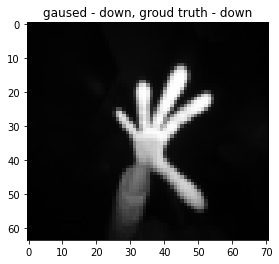

torch.Size([32, 1, 64, 71])
torch.Size([10])


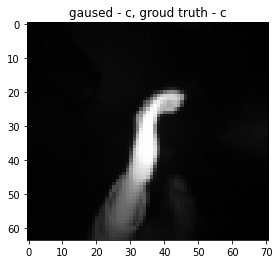

torch.Size([32, 1, 64, 71])
torch.Size([10])


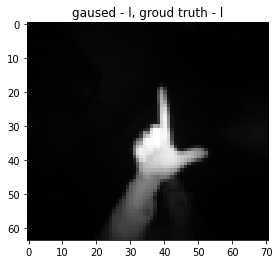

torch.Size([32, 1, 64, 71])
torch.Size([10])


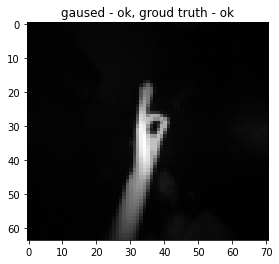

torch.Size([32, 1, 64, 71])
torch.Size([10])


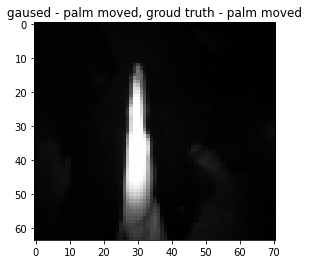

torch.Size([32, 1, 64, 71])
torch.Size([10])


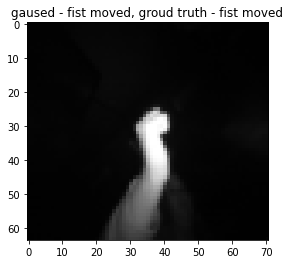

torch.Size([32, 1, 64, 71])
torch.Size([10])


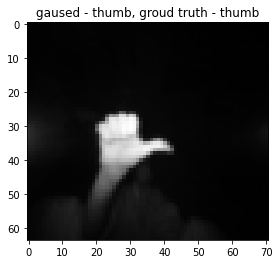

In [33]:
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, labels = data
        images, labels = images, labels
        outputs = model(images)
        print(images.shape)
        print(outputs[0].shape)
        plt.title(f'gaused - {digit_to_classname[outputs[0].argmax().item()]}, groud truth - {digit_to_classname[labels[0].data.item()]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

In [31]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

15 epochs, 438 total_steps per epoch


Text(0.5, 1.0, 'losses vs. No. of epochs')

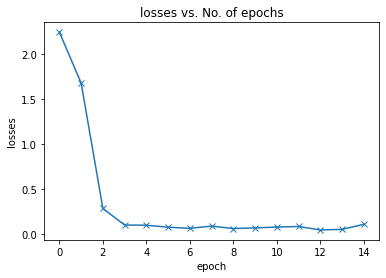

In [32]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

### Напишем скрипт, в котором мы построим пайплайн для распознавания лица человека в кадре и какой жест человек показывает рукой.

In [ ]:
import numpy as np
from facenet_pytorch import MTCNN
from PIL import Image
import mediapipe as mp
import cv2
 
class FaceDetector(object):

    def __init__(self, mtcnn, mp, resnet,channels=1):
        # Создаем объект для считывания потока с веб-камеры(обычно основная вебкамера идет под номером 0, дополнительная - 1)
        self.cap = cv2.VideoCapture(0) 
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = resnet
        self.channels = channels
        self.mp = mp

    def _draw(self, frame, boxes, probs, landmarks):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                cv2.rectangle(frame,
                              (int(box[0]), int(box[1])),
                              (int(box[2]), int(box[3])),
                              (0, 0, 255),
                              thickness=2)
                
        except Exception as e:
            print('Something wrong im draw function!')
            print(f'error : {e}')

        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]-40):int(box[3]+40), 
                int(box[0]-40):int(box[2]+40)])
#             print(box)
        return faces
    
    @staticmethod
    def crop_hands(frame, hand_boxes):
        hands = []
        for i, hand_box in enumerate(hand_boxes):
            hands.append(frame[int(hand_box[1]-60):int(hand_box[3]+60), 
                int(hand_box[0]-60):int(hand_box[2]+60)])
        return hands
    
    @staticmethod
    def digit_to_classname(digit):

        if num == 0:
            return 'palm'
        elif num == 1:
            return 'l'
        elif num == 2:
            return 'fist'
        elif num == 3:
            return 'fist_moved'
        elif num == 4:
            return 'thumb'
        elif num == 5:
            return 'index'
        elif num == 6:
            return 'ok'
        elif num == 7:
            return 'palm_moved'
        elif num == 8:
            return 'c'
        elif num == 9:
            return 'down'
            
        
        
    @staticmethod
    def remove_background(frame):
        bgModel = cv2.createBackgroundSubtractorMOG2(0, 50)
        fgmask = bgModel.apply(frame, learningRate=0)
        kernel = np.ones((3, 3), np.uint8)
        fgmask = cv2.erode(fgmask, kernel, iterations=1)
        res = cv2.bitwise_and(frame, frame, mask=fgmask)
        return res  
    
    # Функция для считывания кадров:
    def run(self):

        blurValue = 5
        
        mp_drawing = self.mp.solutions.drawing_utils
        mp_hands = self.mp.solutions.hands
        with mp_hands.Hands(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
            while True:
                ret, frame = self.cap.read()
                h, w, c = frame.shape
                try:
                    boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)

                    # Вырезаем лицо из кадра
                    face = self.crop_faces(frame, boxes)[0]

                    # Рисуем на кадре
                    self._draw(frame, boxes, probs, landmarks)

                    frame = cv2.cvtColor(cv2.flip(frame, 1), cv2.COLOR_BGR2RGB)
                    frame.flags.writeable = False
                    results = hands.process(frame)

                    # Draw the hand annotations on the image.
                    frame.flags.writeable = True
                    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                    hand_landmarks = results.multi_hand_landmarks
                    if hand_landmarks:
                        hand_boxes = []
                        for handLMs in hand_landmarks:
                            x_max = 0
                            y_max = 0
                            x_min = w
                            y_min = h
                            
                            for lm in handLMs.landmark:
                               
                                x, y = int(lm.x * w), int(lm.y * h)
                                if x > x_max:
                                    x_max = x
                                if x < x_min:
                                    x_min = x
                                if y > y_max:
                                    y_max = y
                                if y < y_min:
                                    y_min = y

                        hand_box = [x_min, y_min, x_max, y_max]
                        hand_boxes.append(hand_box)

                        # Вырезаем руку из кадра
                        hand = self.crop_hands(frame, hand_boxes)[0]
                        
                        # Меняем размер изображения для входа в нейронную сеть
                        hand_img = cv2.resize(hand,(71,64))
                        
                        hand = cv2.cvtColor(hand_img, cv2.COLOR_BGR2RGB)
                        # Превращаем в 1-канальное серое изображение
                        hand = cv2.cvtColor(hand, cv2.COLOR_BGR2GRAY)
                        hand = cv2.GaussianBlur(hand, (blurValue, blurValue), 0)
                        # Превращаем в 1-канальное черно-белое изображение
                        (thresh, hand) = cv2.threshold(hand, 60, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                        cv2.imshow('bwhand', hand)

                        # Далее мы подготавливаем наш кадр для считывания нейросетью
                        # Для этого перегоним его в формат pil_image
                        hand = Image.fromarray(hand)
                        hand = np.asarray(hand).astype('float')
                        hand = torch.as_tensor(hand)

                        torch_hand = hand.unsqueeze(0).to(self.device).float()
                        # Загужаем наш тензор в нейронную сеть и получаем предсказание
                        emotion = self.emodel(torch_hand[None, ...])
                        print(emotion[0])
                        # Интерпретируем предсказание как строку нашей эмоции
                        emotion[0][3] = emotion[0][3]/1000
                        emotion = self.digit_to_classname(emotion[0].argmax().item())
                        hand_cv = cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                        cv2.putText(frame, emotion,
                             (x_max, y_max), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                        
                except Exception as e:
                    print('Something wrong im main cycle!')
                    print(f'error : {e}')

                # Показываем кадр в окне, и назвываем его(окно) - 'Hands Detection'
                cv2.imshow('Hands Detection', frame)


                # Функция для выхода из цикла путем нажатия на клавишу 'q'
                # Если нажатие произошло - конец работы приложения
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            # Очищаем все объекты opencv, что мы создали
        self.cap.release()
        cv2.destroyAllWindows()

In [ ]:
mtcnn = MTCNN()
device = torch.device("cuda")
model = torch.load('./gesture_classification_model.pth').to(device)

model.eval()
# Создаем объект нашего класса приложения

fcd = FaceDetector(mtcnn, mp, model)

# Запускаем
fcd.run()